In [1]:
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import numpy as np
import os
import sys
import tensorflow as tf

import gym

In [2]:
env = gym.make('CartPole-v0')

n_iterations = 1000

def action(obs):
    chosen_action = 0
    if obs > 0:
        chosen_action = 1

    return chosen_action

mean_total_reward = 0
highest_reward = 0
lowest_reward = 50
reward_per_game = []

for game in range(n_iterations):
    obs = env.reset()
    temp_reward = 0
    for _ in range(200):
        
        obs, reward, done, info = env.step(action(obs[2]))
        mean_total_reward += reward
        temp_reward += reward
        if done: break
    if highest_reward < temp_reward:
        highest_reward = temp_reward

    if lowest_reward > temp_reward:
        lowest_reward = temp_reward
    reward_per_game.append(temp_reward)

print("Mean reward", mean_total_reward/n_iterations, "Highest Reward", highest_reward, "Lowest Reward", lowest_reward)


Mean reward 41.924 Highest Reward 72.0 Lowest Reward 24.0


<IPython.core.display.Javascript object>


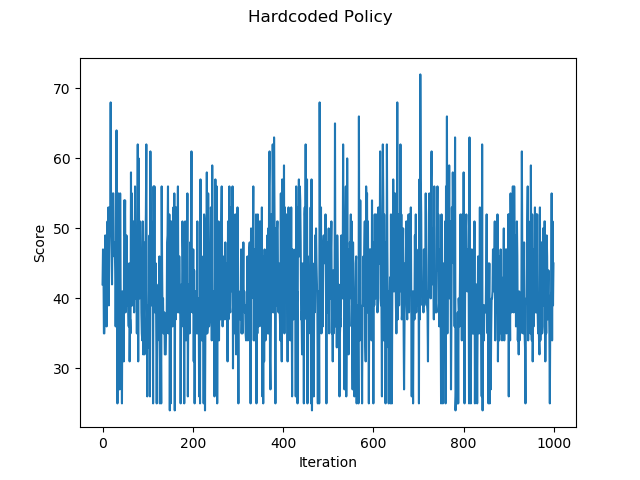

Text(0,0.5,'Score')

In [3]:
fig = plt.figure()

plt.plot(reward_per_game)

fig.suptitle('Hardcoded Policy')
plt.xlabel('Iteration')
plt.ylabel('Score')

In [2]:
env = gym.make('CartPole-v0')
env.reset()


n_inputs = 4
n_hidden = 16
n_outputs = 1

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
hidden2 = tf.layers.dense(hidden, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)

logits = tf.layers.dense(hidden2, n_outputs, kernel_initializer=initializer)

outputs = tf.nn.sigmoid(logits)

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)

learning_rate = 0.01

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)

gradients = [grad for grad, variable in grads_and_vars]

gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    total_rewards = 0
    for step in reversed(range(len(rewards))):
        total_rewards = rewards[step] + total_rewards * discount_rate
        discounted_rewards[step] = total_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]

    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]



In [ ]:
n_iterations = 250
n_max_steps = 200
n_games_per_update = 10
save_interations = 10
discount_rate = 0.95
plot_reward = []

iteration_mean = 10
converge = False
converge_TimeStep = 0
numberOfIterationsAbove190 = 0

with tf.Session() as sess:
    init.run()
    
    for iteration in range(n_iterations):
        rewards_per_tengame = 0
        all_rewards = []
        all_gradients = []
        
        for game in range(n_games_per_update):
            total_reward = 0
            current_rewards = []
            current_gradients = []

            obs = env.reset()
            for step in range(n_max_steps):
                if(converge):
                    env.render()
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X:obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                
                total_reward += reward
                if done: break
            
            rewards_per_tengame += total_reward
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        feed_dict = {}
        
        
       
            
        
       
        
        plot_reward.append(rewards_per_tengame/n_games_per_update)
        
        print(iteration)
        if(iteration > iteration_mean) :
            currentMean = 0
            for i in range(iteration-iteration_mean,iteration) :
                currentMean += plot_reward[i]
            currentMean = currentMean/iteration_mean
            
            print(currentMean)
            if (currentMean > 190):
                print("we Have Convergence suckers!")
                converge = True
                converge_TimeStep = iteration
                
        
        

        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward*all_gradients[game_index][step][var_index] 
                                      for game_index, rewards in enumerate(all_rewards) 
                                      for step, reward in enumerate(rewards)], axis=0)
            feed_dict[grad_placeholder] = mean_gradients

        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_interations == 0:
            saver.save(sess, "./mypolicy_net_pg.ckpt")
    
    


0
1
2
3
4
5
6
7
8
9
10
11
32.059999999999995
12
36.3
13
42.5
14
47.739999999999995
15
51.21
16
54.08
17
60.8
18
65.66
19
71.22999999999999
20
75.75
21
80.35
22
84.19
23
88.36999999999999
24
96.97999999999999
25
107.71999999999998
26
118.7
27
124.86999999999998
28
131.61999999999998
29
139.66
30
148.04000000000002
31
154.77
32
160.2
33
163.78
34
162.95999999999998
35
157.8
36
153.7
37
151.22
38
149.93
39
147.23000000000002
40
146.52
41
145.18
42
146.43
43
148.39
44
152.23
45
158.57
46
165.44
47
172.60999999999999
48
178.62
49
183.28
50
186.35
51
190.49
we Have Convergence suckers!
52
192.97
we Have Convergence suckers!
53
195.52
we Have Convergence suckers!
54
196.76
we Have Convergence suckers!
55
198.0
we Have Convergence suckers!
56
198.6
we Have Convergence suckers!
57
198.6
we Have Convergence suckers!
58
198.6
we Have Convergence suckers!
59
198.6
we Have Convergence suckers!


<IPython.core.display.Javascript object>


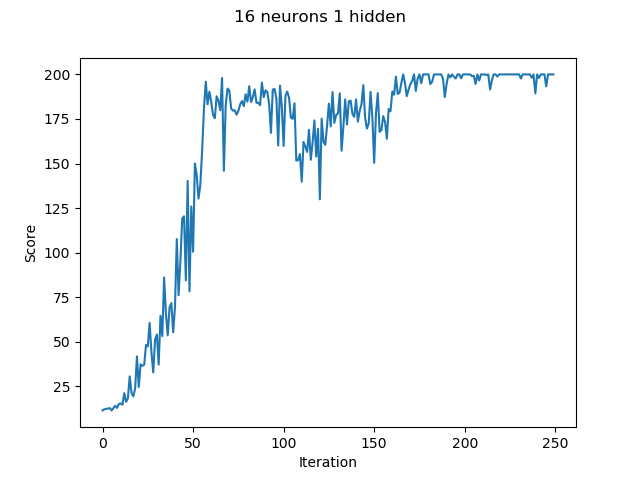

Text(0,0.5,'Score')

In [4]:
fig = plt.figure()

plt.plot(plot_reward)

fig.suptitle('16 neurons 1 hidden')
plt.xlabel('Iteration')
plt.ylabel('Score')